In [ ]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import urllib.request
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool, cpu_count

# ============================================
# 1. Wczytanie danych
# ============================================

def load_data():

    url = "https://raw.githubusercontent.com/mastqe/tsplib/master/kroA150.tsp"

    with urllib.request.urlopen(url) as f:
        lines = f.read().decode("utf-8").strip().splitlines()

    coords = []
    node_section = False

    for line in lines:
        line = line.strip()
        if line == "NODE_COORD_SECTION":
            node_section = True
            continue
        if line == "EOF":
            break
        if node_section:
            parts = line.split()
            if len(parts) >= 3:
                # format: id x y
                _id = int(parts[0])
                x = float(parts[1])
                y = float(parts[2])
                coords.append((x, y))

    coords = np.array(coords)
    return coords

coords = load_data()
n_cities = coords.shape[0]
print("Liczba miast:", n_cities)


Liczba miast: 150


In [ ]:
# ============================================
# 2. Macierz odległości
# ============================================

def build_distance_matrix(coords):
    """
    Tworzy macierz odległości zgodną z EUC_2D :
    """
    diff = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]
    dist = np.sqrt(np.sum(diff ** 2, axis=2))
    dist = np.rint(dist).astype(int)
    return dist

dist_matrix = build_distance_matrix(coords)

In [ ]:
# ============================================
# 3. Reprezentacja rozwiązania i funkcja celu
# ============================================

def random_individual(n):
    """Losowa permutacja miast."""
    perm = np.arange(n)
    np.random.shuffle(perm)
    return perm

def tour_length(individual, dist_matrix):
    """
    Liczy długość cyklu TSP:
    miasto[0] -> miasto[1] -> ... -> miasto[n-1] -> miasto[0]
    """
    total = 0
    n = len(individual)
    for i in range(n - 1):
        a = individual[i]
        b = individual[i + 1]
        total += dist_matrix[a, b]
    # powrót do startu
    total += dist_matrix[individual[-1], individual[0]]
    return total

In [ ]:
# ============================================
# 4. GA - operatory: selekcja, krzyżowanie, mutacja
# ============================================

def tournament_selection(population, fitness, k=3):
    """
    Selekcja turniejowa:
    losujemy k osobników i wybieramy najlepszy (min fitness).
    """
    idxs = np.random.choice(len(population), size=k, replace=False)
    best_idx = idxs[np.argmin(fitness[idxs])]
    return population[best_idx]

def order_crossover(p1, p2):
    """
    Order Crossover (OX) dla permutacji.
    Zwraca jedno dziecko.
    """
    n = len(p1)
    a, b = sorted(np.random.randint(0, n, size=2))
    child = np.full(n, -1, dtype=int)

    # środkowy fragment z p1
    child[a:b+1] = p1[a:b+1]

    # uzupełnianie reszty kolejno z p2
    pos = (b + 1) % n
    for gene in p2:
        if gene not in child:
            child[pos] = gene
            pos = (pos + 1) % n
    return child

def mutate_swap(individual):
    """
    Mutacja: zamiana dwóch losowych genów miejscami.
    """
    n = len(individual)
    i, j = np.random.randint(0, n, size=2)
    individual[i], individual[j] = individual[j], individual[i]

In [ ]:
# ============================================
# 5. Helper: krzyżowanie + mutacja dla pary rodziców
#    (będzie wywoływany równolegle w wątkach)
# ============================================

def crossover_and_mutate_pair(args):
    """
    Przyjmuje krotkę:
        (parent1, parent2, crossover_rate, mutation_rate)
    Zwraca parę (child1, child2).
    """
    parent1, parent2, crossover_rate, mutation_rate = args

    # krzyżowanie
    if np.random.rand() < crossover_rate:
        child1 = order_crossover(parent1, parent2)
        child2 = order_crossover(parent2, parent1)
    else:
        child1 = parent1.copy()
        child2 = parent2.copy()

    # mutacja
    if np.random.rand() < mutation_rate:
        mutate_swap(child1)
    if np.random.rand() < mutation_rate:
        mutate_swap(child2)

    return child1, child2

In [ ]:
# ============================================
# 6. Ewaluacja populacji – sekwencyjna
# ============================================

def evaluate_population_seq(population, dist_matrix):
    """
    SEKWENCYJNA wersja – liczy fitness po kolei w pętli.
    """
    fitness = [tour_length(ind, dist_matrix) for ind in population]
    return np.array(fitness)


2

In [ ]:
# ============================================
# 7. Główna pętla GA z równoległym krzyżowaniem
# ============================================

def genetic_algorithm_tsp(
    dist_matrix,
    n_generations=300,
    population_size=200,
    crossover_rate=0.9,
    mutation_rate=0.2,
    tournament_k=3,
    elitism=True,
    parallel_crossover=True
):
    n = dist_matrix.shape[0]

    # Inicjalizacja populacji
    population = np.array([random_individual(n) for _ in range(population_size)])
    best_cost_history = []
    best_indiv_history = []

    for gen in range(n_generations):
        # --- ewaluacja populacji (SEKWENCYJNIE) ---
        fitness = evaluate_population_seq(population, dist_matrix)

        # najlepszy osobnik w tej generacji
        best_idx = np.argmin(fitness)
        best_ind = population[best_idx].copy()
        best_cost = fitness[best_idx]

        best_cost_history.append(best_cost)
        best_indiv_history.append(best_ind)

        if gen % 50 == 0 or gen == n_generations - 1:
            mode = "PAR_X" if parallel_crossover else "SEQ_X"
            print(f"[{mode}] Pokolenie {gen:4d} | najlepszy koszt: {best_cost}")

        # --- tworzenie nowej populacji ---
        new_population = []

        # Elita – przeniesienie najlepszego osobnika bez zmian
        if elitism:
            new_population.append(best_ind)

        # ile osobników musimy jeszcze wygenerować krzyżowaniem
        remaining = population_size - len(new_population)
        num_pairs = (remaining + 1) // 2  # liczba par rodziców

        # 1) wybieramy pary rodziców
        parent_pairs_args = []
        for _ in range(num_pairs):
            p1 = tournament_selection(population, fitness, k=tournament_k)
            p2 = tournament_selection(population, fitness, k=tournament_k)
            parent_pairs_args.append((p1, p2, crossover_rate, mutation_rate))

        # 2) krzyżowanie + mutacja – SEKWENCYJNIE lub RÓWNOLEGLE
        children = []
        if parallel_crossover:
            # wielu procesów (bez GIL)
            with Pool(processes=2) as pool:
                results = pool.map(crossover_and_mutate_pair, parent_pairs_args)
            for (child1, child2) in results:
                children.append(child1)
                children.append(child2)
        else:
            # wersja sekwencyjna
            for args in parent_pairs_args:
                child1, child2 = crossover_and_mutate_pair(args)
                children.append(child1)
                children.append(child2)

        # 3) ucinamy nadmiar dzieci, jeśli powstało ich za dużo
        children = children[:remaining]

        new_population.extend(children)

        population = np.array(new_population)

    # Po ostatnim pokoleniu – najlepszy ze wszystkich pokoleń
    best_overall_idx = np.argmin(best_cost_history)
    best_overall_cost = best_cost_history[best_overall_idx]
    best_overall_ind = best_indiv_history[best_overall_idx]

    return best_overall_ind, best_overall_cost, best_cost_history

# ============================================
# 8. Pomiar czasu: sekwencyjne vs równoległe krzyżowanie
# ============================================

def run_and_time_crossover(parallel_crossover, label, **ga_kwargs):
    np.random.seed(42)

    start = time.perf_counter()
    best_tour, best_cost, history = genetic_algorithm_tsp(
        dist_matrix,
        parallel_crossover=parallel_crossover,
        **ga_kwargs
    )
    end = time.perf_counter()
    elapsed = end - start

    print(f"\n[{label}] czas: {elapsed:.3f} s | najlepszy koszt: {best_cost}")
    return elapsed, best_cost, history, best_tour

ga_params = dict(
    n_generations=200,
    population_size=600,
    crossover_rate=0.9,
    mutation_rate=0.2,
    tournament_k=3,
    elitism=True
)

print("=== Pojedyncze porównanie (krzyżowanie) ===")
t_seq, c_seq, h_seq, tour_seq = run_and_time_crossover(False, "SEQ_X", **ga_params)
t_par, c_par, h_par, tour_par = run_and_time_crossover(True, "PAR_X", **ga_params)

speedup = t_seq / t_par if t_par > 0 else float('inf')
print(f"\nPrzyspieszenie (speedup) = czas_seq / czas_par = {speedup:.3f}")

=== Pojedyncze porównanie (krzyżowanie) ===
[SEQ_X] Pokolenie    0 | najlepszy koszt: 223901
[SEQ_X] Pokolenie   50 | najlepszy koszt: 158049
[SEQ_X] Pokolenie  100 | najlepszy koszt: 139598
[SEQ_X] Pokolenie  150 | najlepszy koszt: 133983
[SEQ_X] Pokolenie  199 | najlepszy koszt: 121451

[SEQ_X] czas: 88.299 s | najlepszy koszt: 121451
[PAR_X] Pokolenie    0 | najlepszy koszt: 223901
[PAR_X] Pokolenie   50 | najlepszy koszt: 160614
[PAR_X] Pokolenie  100 | najlepszy koszt: 138653
[PAR_X] Pokolenie  150 | najlepszy koszt: 128460
[PAR_X] Pokolenie  199 | najlepszy koszt: 114321

[PAR_X] czas: 103.449 s | najlepszy koszt: 114321

Przyspieszenie (speedup) = czas_seq / czas_par = 0.854



--- RUN 1/3 ---
[SEQ_X] Pokolenie    0 | najlepszy koszt: 223901
[SEQ_X] Pokolenie   50 | najlepszy koszt: 158049
[SEQ_X] Pokolenie  100 | najlepszy koszt: 139598
[SEQ_X] Pokolenie  150 | najlepszy koszt: 133983
[SEQ_X] Pokolenie  199 | najlepszy koszt: 121451

[SEQ_X] czas: 88.843 s | najlepszy koszt: 121451
[PAR_X] Pokolenie    0 | najlepszy koszt: 223901
[PAR_X] Pokolenie   50 | najlepszy koszt: 149924
[PAR_X] Pokolenie  100 | najlepszy koszt: 138773
[PAR_X] Pokolenie  150 | najlepszy koszt: 124385
[PAR_X] Pokolenie  199 | najlepszy koszt: 115988

[PAR_X] czas: 103.330 s | najlepszy koszt: 115988

--- RUN 2/3 ---
[SEQ_X] Pokolenie    0 | najlepszy koszt: 223901
[SEQ_X] Pokolenie   50 | najlepszy koszt: 158049
[SEQ_X] Pokolenie  100 | najlepszy koszt: 139598
[SEQ_X] Pokolenie  150 | najlepszy koszt: 133983
[SEQ_X] Pokolenie  199 | najlepszy koszt: 121451

[SEQ_X] czas: 89.089 s | najlepszy koszt: 121451
[PAR_X] Pokolenie    0 | najlepszy koszt: 223901
[PAR_X] Pokolenie   50 | najlep

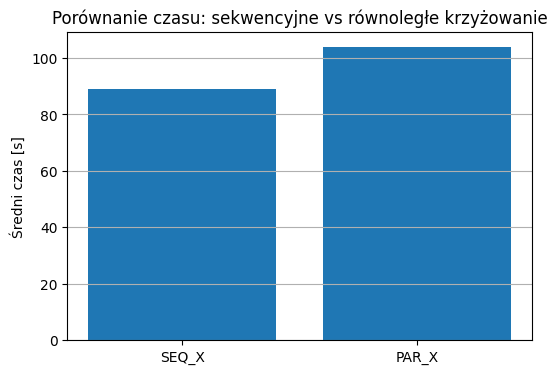

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def measure_times(runs=5):
    times_seq = []
    times_par = []

    for i in range(runs):
        print(f"\n--- RUN {i+1}/{runs} ---")
        t_seq, _, _, _ = run_and_time_crossover(False, "SEQ_X", **ga_params)
        t_par, _, _, _ = run_and_time_crossover(True, "PAR_X", **ga_params)
        times_seq.append(t_seq)
        times_par.append(t_par)

    return np.array(times_seq), np.array(times_par)

# liczba powtórzeń
runs = 3
times_seq, times_par = measure_times(runs=runs)

# obliczenie średnich czasów
avg_seq = times_seq.mean()
avg_par = times_par.mean()
speedup = avg_seq / avg_par if avg_par > 0 else float('inf')

print("\n=== PODSUMOWANIE ===")
print(f"Średni czas SEQ_X: {avg_seq:.3f} s")
print(f"Średni czas PAR_X: {avg_par:.3f} s")
print(f"Średni speedup (SEQ / PAR): {speedup:.3f}")

# wykres słupkowy
labels = ["SEQ_X", "PAR_X"]
avg_times = [avg_seq, avg_par]

plt.figure(figsize=(6,4))
plt.bar(labels, avg_times)
plt.ylabel("Średni czas [s]")
plt.title("Porównanie czasu: sekwencyjne vs równoległe krzyżowanie")
plt.grid(axis="y")
plt.show()
